# Project Report
By Michael Geiger

### Project Overview
For my data science project this semester, I would like to investigate how accurately you can predict whether or not the outcome of an NFL game will fall within the projected outcome (right winner predicted), the points that the winning team will win by (spread), and the combined points (over/under) for a specific game. These predictions will be based on historical betting data, NFL game matchups and outcomes, and various environmental conditions such as stadium location and weather conditions. I will also be merging in external population data to see how additional information affects the accuracy of this model. With the rise of sports gambling in all professional sports in the United States, a predictive model that can accurate prove/disprove projected betting odds for any game is an incredibly valuable tool. With the NFL being one of the most popular sports in the US, a predictive tool for personal-gambling purposes would be incredibly valuable for use in states where sports gambling is currently legal. 

In [678]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import codecs
import statsmodels.formula.api as smf
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
sns.set_context('talk')
sns.set_style('darkgrid')
sns.set_palette('colorblind')

#### Let's start by importing our datasets.

In [679]:
nfl_teams = pd.read_csv("nfl_teams.csv")
nfl_stadiums = pd.read_csv("nfl_stadiums.csv", encoding='cp437')
nfl_scores = pd.read_csv("spreadspoke_scores.csv")

## Cleaning the Datasets

#### NFL Teams Dataset

This dataset has teams that were in the league before my desired "cutoff date" of 2010, so their information will not be relevant in this analysis.

In [680]:
cleaned_teams = nfl_teams.drop(labels=[1,2,15,20,22,26,30,37,38])\
                         .drop(labels=['team_name_short','team_id_pfr','team_conference_pre2002',
                                       'team_division_pre2002'],axis=1)\
                         .reset_index(drop=True)

In [681]:
cleaned_teams.columns=['Team', 'Team ID', 'Conference', 'Division']
cleaned_teams

,Team,Team ID,Conference,Division
0,Arizona Cardinals,ARI,NFC,NFC West
1,Atlanta Falcons,ATL,NFC,NFC South
2,Baltimore Ravens,BAL,AFC,AFC North
3,Buffalo Bills,BUF,AFC,AFC East
4,Carolina Panthers,CAR,NFC,NFC South
5,Chicago Bears,CHI,NFC,NFC North
6,Cincinnati Bengals,CIN,AFC,AFC North
7,Cleveland Browns,CLE,AFC,AFC North
8,Dallas Cowboys,DAL,NFC,NFC East
9,Denver Broncos,DEN,AFC,AFC West


#### NFL Stadiums Dataset

First, we'll drop columns that are either redundant to other columns or not relevant to this analysis. The address of the stadium is essentially the same as the stadium location, which is a column in the NFL Scores Dataset. The weather station and radio station information are deemed not relevant due to their extremely loose indirect impact on the outcome of the game. Lat/Long is removed because it is also redundant.

In [682]:
stadiums = nfl_stadiums.drop(labels=['stadium_address','stadium_weather_station_code','stadium_open',
                                     'stadium_close','STATION','NAME','LATITUDE','LONGITUDE'], axis=1)
stadiums.head()

,stadium_name,stadium_location,stadium_type,stadium_weather_type,stadium_capacity,stadium_surface,ELEVATION
0,Alamo Dome,"San Antonio, TX",indoor,dome,72000,FieldTurf,NaN
1,Alltel Stadium,"Jacksonville, FL",NaN,NaN,NaN,NaN,NaN
2,Alumni Stadium,"Chestnut Hill, MA",outdoor,cold,NaN,Grass,NaN
3,Anaheim Stadium,"Anaheim, CA",outdoor,warm,NaN,NaN,NaN
4,Arrowhead Stadium,"Kansas City, MO",outdoor,cold,"76,416",Grass,264.9


#### NFL Scores Dataset

First, we need to convert the original dataset containing all NFL games played since 1966 to only the regular season games played since 2010 for this analysis. 

In [683]:
recent_regscores = nfl_scores.loc[lambda nfl_scores: nfl_scores['schedule_season'] >= 2010]\
                             .loc[lambda nfl_scores: nfl_scores['schedule_playoff'] == False]\
                             .loc[lambda nfl_scores: nfl_scores['stadium_neutral'] == False]
recent_regscores = recent_regscores.drop(labels=['schedule_playoff','stadium_neutral'], axis=1)
recent_regscores.head()

,schedule_date,schedule_season,schedule_week,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,over_under_line,stadium,weather_temperature,weather_wind_mph,weather_humidity,weather_detail
10008,09/09/2010,2010,1,New Orleans Saints,14,9,Minnesota Vikings,NO,-5.0,49.5,Louisiana Superdome,72.0,0.0,NaN,DOME
10009,09/12/2010,2010,1,Buffalo Bills,10,15,Miami Dolphins,MIA,-3.0,39,Ralph Wilson Stadium,64.0,7.0,81,NaN
10010,09/12/2010,2010,1,Chicago Bears,19,14,Detroit Lions,CHI,-6.5,45,Soldier Field,75.0,1.0,45,NaN
10011,09/12/2010,2010,1,Houston Texans,34,24,Indianapolis Colts,IND,-1.0,48,Reliant Stadium,89.0,5.0,NaN,DOME (Open Roof)
10012,09/12/2010,2010,1,Jacksonville Jaguars,24,17,Denver Broncos,JAX,-3.0,41.5,EverBank Field,91.0,1.0,67,NaN


Now we'll observe how much data is missing.

DOME                    538
Rain                     98
DOME (Open Roof)         56
Fog                      25
Rain | Fog               18
Snow                     13
Snow | Fog                5
Snow | Freezing Rain      1
Name: weather_detail, dtype: int64


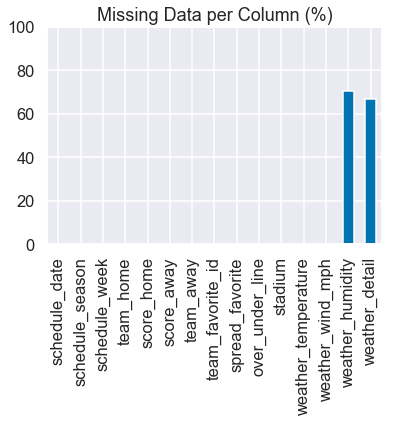

In [684]:
missings = recent_regscores.isnull().sum()/len(recent_regscores)*100
missings.plot.bar(title='Missing Data per Column (%)',ylim=[0,100])
print(recent_regscores['weather_detail'].value_counts())

More than 60% of the data for humidity and weather detail information is mission, so it will be omitted from this study. 

In [685]:
recent_regscores = recent_regscores.drop(labels=['weather_humidity','weather_detail'], axis=1)
recent_regscores.head()

,schedule_date,schedule_season,schedule_week,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,over_under_line,stadium,weather_temperature,weather_wind_mph
10008,09/09/2010,2010,1,New Orleans Saints,14,9,Minnesota Vikings,NO,-5.0,49.5,Louisiana Superdome,72.0,0.0
10009,09/12/2010,2010,1,Buffalo Bills,10,15,Miami Dolphins,MIA,-3.0,39,Ralph Wilson Stadium,64.0,7.0
10010,09/12/2010,2010,1,Chicago Bears,19,14,Detroit Lions,CHI,-6.5,45,Soldier Field,75.0,1.0
10011,09/12/2010,2010,1,Houston Texans,34,24,Indianapolis Colts,IND,-1.0,48,Reliant Stadium,89.0,5.0
10012,09/12/2010,2010,1,Jacksonville Jaguars,24,17,Denver Broncos,JAX,-3.0,41.5,EverBank Field,91.0,1.0


In [686]:
recent_regscores['team_home'].value_counts()

New England Patriots    72
Arizona Cardinals       72
Seattle Seahawks        72
Houston Texans          72
Indianapolis Colts      72
Denver Broncos          72
Philadelphia Eagles     72
Green Bay Packers       72
Tennessee Titans        72
New York Jets           72
Dallas Cowboys          72
Baltimore Ravens        72
New York Giants         72
Pittsburgh Steelers     72
Carolina Panthers       72
Detroit Lions           72
Washington Redskins     72
Chicago Bears           72
New Orleans Saints      72
Cleveland Browns        71
Tampa Bay Buccaneers    71
Cincinnati Bengals      71
Atlanta Falcons         71
Kansas City Chiefs      71
San Francisco 49ers     71
Minnesota Vikings       70
Miami Dolphins          70
Oakland Raiders         68
Buffalo Bills           68
Jacksonville Jaguars    66
San Diego Chargers      56
St. Louis Rams          47
Los Angeles Rams        22
Los Angeles Chargers    15
Name: team_home, dtype: int64

Here, we can see that the Chargers and Rams both changed, locations since 2010, so they will both be merged to their current franchise names for simplicity's sake.

In [687]:
scores = recent_regscores.replace(to_replace='San Diego Chargers',value='Los Angeles Chargers')\
                         .replace(to_replace='St. Louis Rams',value='Los Angeles Rams')

## Time to Merge all 3 Datasets

In [688]:
data = scores.merge(cleaned_teams, how='left', left_on='team_home', right_on='Team')\
             .merge(cleaned_teams, how='left',left_on='team_away',right_on='Team',suffixes=('_Home','_Away'))\
             .drop(labels=['Team_Home','Team_Away','team_home','team_away'],axis=1)
data = data.merge(stadiums,how='left',left_on='stadium',right_on='stadium_name')\
           .drop(labels=['stadium_name','stadium_weather_type','schedule_date'],axis=1)
data.head()

,schedule_season,schedule_week,score_home,score_away,team_favorite_id,spread_favorite,over_under_line,stadium,weather_temperature,weather_wind_mph,...,Conference_Home,Division_Home,Team ID_Away,Conference_Away,Division_Away,stadium_location,stadium_type,stadium_capacity,stadium_surface,ELEVATION
0,2010,1,14,9,NO,-5.0,49.5,Louisiana Superdome,72.0,0.0,...,NFC,NFC South,MIN,NFC,NFC North,"New Orleans, LA",indoor,"76,468",FieldTurf,NaN
1,2010,1,10,15,MIA,-3.0,39,Ralph Wilson Stadium,64.0,7.0,...,AFC,AFC East,MIA,AFC,AFC East,"Orchard Park, NY",outdoor,"73,967",FieldTurf,178.0
2,2010,1,19,14,CHI,-6.5,45,Soldier Field,75.0,1.0,...,NFC,NFC North,DET,NFC,NFC North,"Chicago, IL",outdoor,"61,500",Grass,177.7
3,2010,1,34,24,IND,-1.0,48,Reliant Stadium,89.0,5.0,...,AFC,AFC South,IND,AFC,AFC South,"Houston, TX",retractable,"71,500",Grass,13.4
4,2010,1,24,17,JAX,-3.0,41.5,EverBank Field,91.0,1.0,...,AFC,AFC South,DEN,AFC,AFC West,"Jacksonville, FL",outdoor,"67,264",Grass,6.1


Now to observe how much information is missing after the merge.

schedule_season          0
schedule_week            0
score_home               0
score_away               0
team_favorite_id         0
spread_favorite          0
over_under_line          0
stadium                  0
weather_temperature      0
weather_wind_mph         0
Team ID_Home             0
Conference_Home          0
Division_Home            0
Team ID_Away             0
Conference_Away          0
Division_Away            0
stadium_location        86
stadium_type            86
stadium_capacity       265
stadium_surface        265
ELEVATION              394
dtype: int64


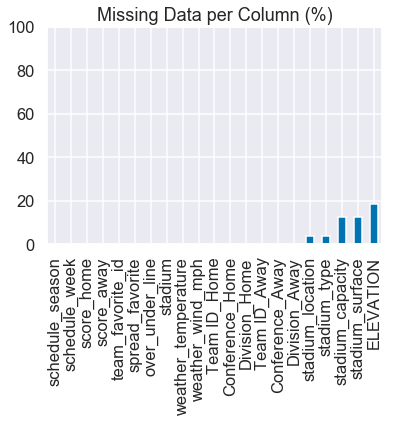

In [689]:
missing_data = data.isnull().sum()
print(missing_data)
missing_data = data.isnull().sum()/len(missing_data)
missing_data.plot.bar(title='Missing Data per Column (%)',ylim=[0,100])

Since there is such a small % of missing data after merging, it is possible that the data is tied to specific stadiums, so that will be investigated below.

In [690]:
bla = data.loc[lambda data:data['stadium_location'].isnull()==True]
bla['stadium'].value_counts()

FedEx Field              72
Mercedes-Benz Stadium     8
TIAA Bank Field           6
Name: stadium, dtype: int64

In [691]:
bla = data.loc[lambda data:data['stadium_capacity'].isnull()==True]
bla['stadium'].value_counts()

FedEx Field              72
Sun Life Stadium         55
Edward Jones Dome        47
Candlestick Park         31
Mall of America Field    29
TCF Bank Stadium         17
Mercedes-Benz Stadium     8
TIAA Bank Field           6
Name: stadium, dtype: int64

In [692]:
bla = data.loc[lambda data:data['ELEVATION'].isnull()==True]
bla['stadium'].value_counts()

Ford Field                 73
FedEx Field                72
Georgia Dome               63
Louisiana Superdome        56
Edward Jones Dome          47
Mall of America Field      29
U.S. Bank Stadium          24
Mercedes-Benz Superdome    16
Mercedes-Benz Stadium       8
TIAA Bank Field             6
Name: stadium, dtype: int64

All of this information missing will now have to be manually inputted into the dataset. This is done below.

In [693]:
data.loc[data.stadium == 'FedEx Field',['stadium_location','stadium_type','stadium_capacity',
                                        'stadium_surface','ELEVATION']] = 'Landover, MD','outdoor','82,000','Grass','60.0'
data.loc[data.stadium == 'Mercedes-Benz Stadium',['stadium_location','stadium_type','stadium_capacity',
                                                  'stadium_surface','ELEVATION']] = 'Atlanta, GA','retractable','71,000','FieldTurf','310.3'
data.loc[data.stadium == 'TIAA Bank Field',['stadium_location','stadium_type','stadium_capacity',
                                            'stadium_surface','ELEVATION']] = 'Jacksonville, FL','outdoor','67,164','Grass','2.0'
data.loc[data.stadium == 'Edward Jones Dome',['stadium_capacity','stadium_surface',
                                              'ELEVATION']] = '67,277','FieldTurf','142.0'
data.loc[data.stadium == 'Mall of America Field',['stadium_capacity','stadium_surface',
                                                  'ELEVATION']] = '64,121','FieldTurf','260.0'
data.loc[data.stadium == 'Sun Life Stadium',['stadium_capacity','stadium_surface']] = '64,767','Grass'
data.loc[data.stadium == 'Candlestick Park',['stadium_capacity','stadium_surface']] = '69,732','Grass'
data.loc[data.stadium == 'TCF Bank Stadium',['stadium_capacity','stadium_surface']] = '50,805','FieldTurf'
data.loc[data.stadium == 'Ford Field',['ELEVATION']] = '184.0'
data.loc[data.stadium == 'Georgia Dome',['ELEVATION']] = '304.0'
data.loc[data.stadium == 'Louisiana Superdome',['ELEVATION']] = '2.0'
data.loc[data.stadium == 'U.S. Bank Stadium',['ELEVATION']] = '260.0'
data.loc[data.stadium == 'Mercedes-Benz Superdome',['ELEVATION']] = '1.0'

In [694]:
missing_data = data.isnull().sum()
missing_data

schedule_season        0
schedule_week          0
score_home             0
score_away             0
team_favorite_id       0
spread_favorite        0
over_under_line        0
stadium                0
weather_temperature    0
weather_wind_mph       0
Team ID_Home           0
Conference_Home        0
Division_Home          0
Team ID_Away           0
Conference_Away        0
Division_Away          0
stadium_location       0
stadium_type           0
stadium_capacity       0
stadium_surface        0
ELEVATION              0
dtype: int64

Now there's no missing data! 

In [695]:
data.columns

Index(['schedule_season', 'schedule_week', 'score_home', 'score_away',
       'team_favorite_id', 'spread_favorite', 'over_under_line', 'stadium',
       'weather_temperature', 'weather_wind_mph', 'Team ID_Home',
       'Conference_Home', 'Division_Home', 'Team ID_Away', 'Conference_Away',
       'Division_Away', 'stadium_location', 'stadium_type', 'stadium_capacity',
       'stadium_surface', 'ELEVATION'],
      dtype='object')

## Time to clean/simplify this final dataset

First, the temperature column is simplified by converting ranges of temperatures to values of either freezing, cold, mild, warm, or hot.

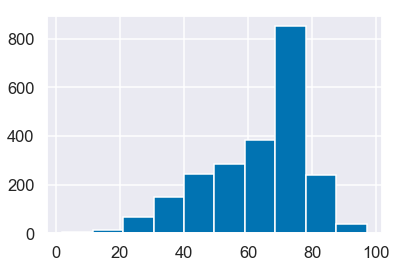

In [696]:
data['weather_temperature'].hist()

In [697]:
temps_dict = {
    'freezing': 32,
    'cold': 45,
    'mild': 60,
    'warm': 75,
    'hot': 200
}

In [698]:
temp_ranges = pd.DataFrame(temps_dict, index=['STOP']).T.reset_index()
temp_ranges['START'] = (temp_ranges.STOP.shift(1)+1).fillna(-200)
temp_ranges.index = pd.IntervalIndex.from_arrays(temp_ranges.START, temp_ranges.STOP, closed='both')
temp_ranges

,index,STOP,START
"[-200.0, 32.0]",freezing,32,-200.0
"[33.0, 45.0]",cold,45,33.0
"[46.0, 60.0]",mild,60,46.0
"[61.0, 75.0]",warm,75,61.0
"[76.0, 200.0]",hot,200,76.0


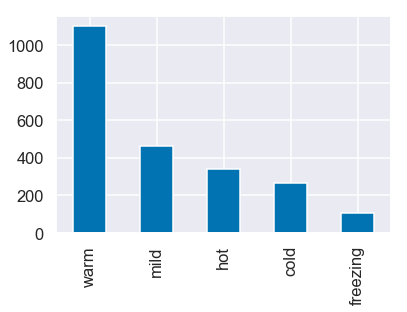

In [699]:
data['weather_temperature'] = data.weather_temperature.map(temp_ranges['index'])
data['weather_temperature'].value_counts().plot(kind='bar')

Next, the wind speed will be classified as either calm, light, gentle, moderate, fresh, or strong based on the Beaufort scale for wind speeds.

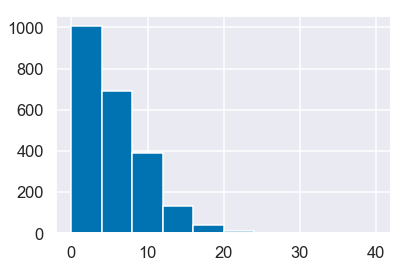

In [700]:
data['weather_wind_mph'].hist()

In [701]:
wind_dict = {
    'calm': 3,
    'light': 7,
    'gentle': 12,
    'moderate': 18,
    'fresh': 24,
    'strong': 100
}

In [702]:
wind_ranges = pd.DataFrame(wind_dict, index=['STOP']).T.reset_index()
wind_ranges['START'] = (wind_ranges.STOP.shift(1)+1).fillna(0)
wind_ranges.index = pd.IntervalIndex.from_arrays(wind_ranges.START, wind_ranges.STOP, closed='both')
wind_ranges

,index,STOP,START
"[0.0, 3.0]",calm,3,0.0
"[4.0, 7.0]",light,7,4.0
"[8.0, 12.0]",gentle,12,8.0
"[13.0, 18.0]",moderate,18,13.0
"[19.0, 24.0]",fresh,24,19.0
"[25.0, 100.0]",strong,100,25.0


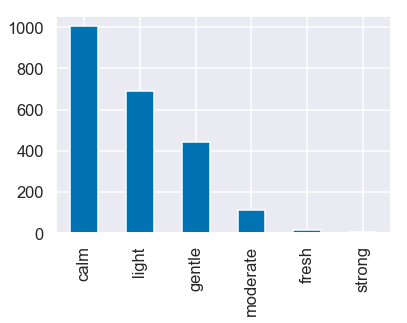

In [703]:
data['weather_wind_mph'] = data.weather_wind_mph.map(wind_ranges['index'])
data['weather_wind_mph'].value_counts().plot(kind='bar')

Next, elevation must be simplified as either low, medium, or high elevation.

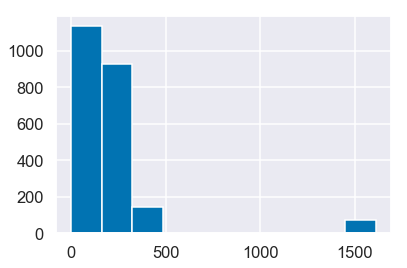

In [704]:
data['ELEVATION'] = data['ELEVATION'].convert_objects(convert_numeric=True)
data['ELEVATION'].hist()

In [705]:
elev_dict = {
    'low': 200,
    'medium': 400,
    'high': 3000
}

In [706]:
elev_ranges = pd.DataFrame(elev_dict, index=['STOP']).T.reset_index()
elev_ranges['START'] = (elev_ranges.STOP.shift(1)+1).fillna(0)
elev_ranges.index = pd.IntervalIndex.from_arrays(elev_ranges.START, elev_ranges.STOP, closed='both')
elev_ranges

,index,STOP,START
"[0.0, 200.0]",low,200,0.0
"[201.0, 400.0]",medium,400,201.0
"[401.0, 3000.0]",high,3000,401.0


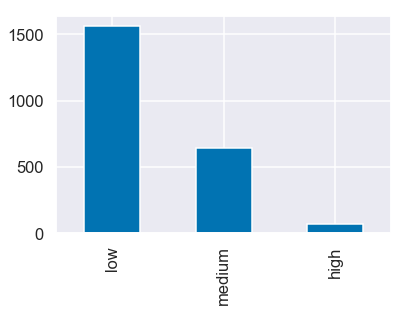

In [707]:
data['ELEVATION'] = data.ELEVATION.map(elev_ranges['index'])
data['ELEVATION'].value_counts().plot(kind='bar')

The same thing must be done for stadium capacity as well: very low, low, medium, high, or very high.

In [708]:
data['stadium_capacity'] = data['stadium_capacity'].str.replace(',','')
data['stadium_capacity'] = data['stadium_capacity'].convert_objects(convert_numeric=True)

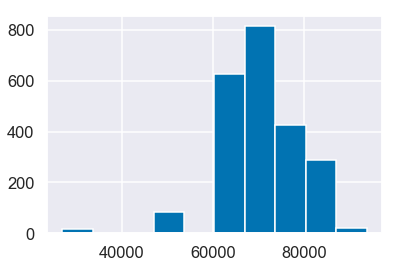

In [709]:
data['stadium_capacity'].hist()

In [710]:
cap_dict = {
    'very low': 40000,
    'low': 60000,
    'medium': 75000,
    'high': 85000,
    'very high': 150000
}

In [711]:
cap_ranges = pd.DataFrame(cap_dict, index=['STOP']).T.reset_index()
cap_ranges['START'] = (cap_ranges.STOP.shift(1)+1).fillna(0)
cap_ranges.index = pd.IntervalIndex.from_arrays(cap_ranges.START, cap_ranges.STOP, closed='both')
cap_ranges

,index,STOP,START
"[0.0, 40000.0]",very low,40000,0.0
"[40001.0, 60000.0]",low,60000,40001.0
"[60001.0, 75000.0]",medium,75000,60001.0
"[75001.0, 85000.0]",high,85000,75001.0
"[85001.0, 150000.0]",very high,150000,85001.0


In [712]:
data['stadium_capacity'] = data.stadium_capacity.map(cap_ranges['index'])
data['stadium_capacity'].value_counts()

medium       1579
high          575
low            85
very high      22
very low       15
Name: stadium_capacity, dtype: int64

Now to take a look at our cleaned dataset:

In [713]:
data.head()

,schedule_season,schedule_week,score_home,score_away,team_favorite_id,spread_favorite,over_under_line,stadium,weather_temperature,weather_wind_mph,...,Conference_Home,Division_Home,Team ID_Away,Conference_Away,Division_Away,stadium_location,stadium_type,stadium_capacity,stadium_surface,ELEVATION
0,2010,1,14,9,NO,-5.0,49.5,Louisiana Superdome,warm,calm,...,NFC,NFC South,MIN,NFC,NFC North,"New Orleans, LA",indoor,high,FieldTurf,low
1,2010,1,10,15,MIA,-3.0,39,Ralph Wilson Stadium,warm,light,...,AFC,AFC East,MIA,AFC,AFC East,"Orchard Park, NY",outdoor,medium,FieldTurf,low
2,2010,1,19,14,CHI,-6.5,45,Soldier Field,warm,calm,...,NFC,NFC North,DET,NFC,NFC North,"Chicago, IL",outdoor,medium,Grass,low
3,2010,1,34,24,IND,-1.0,48,Reliant Stadium,hot,light,...,AFC,AFC South,IND,AFC,AFC South,"Houston, TX",retractable,medium,Grass,low
4,2010,1,24,17,JAX,-3.0,41.5,EverBank Field,hot,calm,...,AFC,AFC South,DEN,AFC,AFC West,"Jacksonville, FL",outdoor,medium,Grass,low


## Adding Additional Features for Analysis

First, we'll add the head-to-head, division-to-division, and conference-to-conference matchup combinations to the data.

In [714]:
data['H2H'] = data[['Team ID_Home', 'Team ID_Away']].apply(lambda x: 'vs'.join(x), axis=1)
data['D2D'] = data[['Division_Home', 'Division_Away']].apply(lambda x: 'vs'.join(x), axis=1)
data['C2C'] = data[['Conference_Home', 'Conference_Away']].apply(lambda x: 'vs'.join(x), axis=1)

In [715]:
data = data.drop(labels = ['Conference_Home','Conference_Away',
                           'Division_Home','Division_Away'], axis=1)
data.head()

,schedule_season,schedule_week,score_home,score_away,team_favorite_id,spread_favorite,over_under_line,stadium,weather_temperature,weather_wind_mph,Team ID_Home,Team ID_Away,stadium_location,stadium_type,stadium_capacity,stadium_surface,ELEVATION,H2H,D2D,C2C
0,2010,1,14,9,NO,-5.0,49.5,Louisiana Superdome,warm,calm,NO,MIN,"New Orleans, LA",indoor,high,FieldTurf,low,NOvsMIN,NFC SouthvsNFC North,NFCvsNFC
1,2010,1,10,15,MIA,-3.0,39,Ralph Wilson Stadium,warm,light,BUF,MIA,"Orchard Park, NY",outdoor,medium,FieldTurf,low,BUFvsMIA,AFC EastvsAFC East,AFCvsAFC
2,2010,1,19,14,CHI,-6.5,45,Soldier Field,warm,calm,CHI,DET,"Chicago, IL",outdoor,medium,Grass,low,CHIvsDET,NFC NorthvsNFC North,NFCvsNFC
3,2010,1,34,24,IND,-1.0,48,Reliant Stadium,hot,light,HOU,IND,"Houston, TX",retractable,medium,Grass,low,HOUvsIND,AFC SouthvsAFC South,AFCvsAFC
4,2010,1,24,17,JAX,-3.0,41.5,EverBank Field,hot,calm,JAX,DEN,"Jacksonville, FL",outdoor,medium,Grass,low,JAXvsDEN,AFC SouthvsAFC West,AFCvsAFC


Next, we'll add the actual over/under line from the final game scores.

In [716]:
data['actual_o_u'] = data['score_home']+data['score_away']
data.head()

,schedule_season,schedule_week,score_home,score_away,team_favorite_id,spread_favorite,over_under_line,stadium,weather_temperature,weather_wind_mph,...,Team ID_Away,stadium_location,stadium_type,stadium_capacity,stadium_surface,ELEVATION,H2H,D2D,C2C,actual_o_u
0,2010,1,14,9,NO,-5.0,49.5,Louisiana Superdome,warm,calm,...,MIN,"New Orleans, LA",indoor,high,FieldTurf,low,NOvsMIN,NFC SouthvsNFC North,NFCvsNFC,23
1,2010,1,10,15,MIA,-3.0,39,Ralph Wilson Stadium,warm,light,...,MIA,"Orchard Park, NY",outdoor,medium,FieldTurf,low,BUFvsMIA,AFC EastvsAFC East,AFCvsAFC,25
2,2010,1,19,14,CHI,-6.5,45,Soldier Field,warm,calm,...,DET,"Chicago, IL",outdoor,medium,Grass,low,CHIvsDET,NFC NorthvsNFC North,NFCvsNFC,33
3,2010,1,34,24,IND,-1.0,48,Reliant Stadium,hot,light,...,IND,"Houston, TX",retractable,medium,Grass,low,HOUvsIND,AFC SouthvsAFC South,AFCvsAFC,58
4,2010,1,24,17,JAX,-3.0,41.5,EverBank Field,hot,calm,...,DEN,"Jacksonville, FL",outdoor,medium,Grass,low,JAXvsDEN,AFC SouthvsAFC West,AFCvsAFC,41


Next, we'll add a feature (boolean value) for whether or not the actual over/under line was below the projected line.

In [717]:
#If the actual over/under of the game is <= the predicted outcome, then the result will be True, meaning
#the 'under' or 'push' occured
data['over_under_line'] = data['over_under_line'].astype(float)
data.loc[(data.actual_o_u <= data.over_under_line), 'Actual_OverUnder'] = True
#If the actual is > the predicted, then the result will be False, meaning the 'over' occured
data.loc[(data.actual_o_u > data.over_under_line), 'Actual_OverUnder'] = False

Next, a feature for whether or not the favorited team actaully won the game (boolean value).

In [718]:
data['actual_spread'] = data['score_home'] - data['score_away']
data.loc[data.actual_spread < 0, 'actual_winner'] = data['Team ID_Away'].loc[data.actual_spread < 0]
data.loc[data.actual_spread == 0, 'actual_winner'] = 'tie'
data.loc[data.actual_spread > 0, 'actual_winner'] = data['Team ID_Home'].loc[data.actual_spread > 0]

In [719]:
data.loc[data.actual_winner == data.team_favorite_id, 'FavoriteWon'] = True
data.loc[data.actual_winner != data.team_favorite_id, 'FavoriteWon'] = False
# ties are converted to False because the favorited team didn't win

When betting on the winner of a game, the winner must win by the projected spread for you to win the bet. Thus, adding an 'Actual_Outcome' column is necessary for determining whether or not the bettor should make the bet.

In [720]:
data.loc[(data.FavoriteWon == True) & (abs(data.actual_spread) <= abs(data.spread_favorite)), 'Actual_Outcome'] = True
data.loc[(data.FavoriteWon == True) & (abs(data.actual_spread) > abs(data.spread_favorite)), 'Actual_Outcome'] = False
data.loc[data.FavoriteWon == False, 'Actual_Outcome'] = False #if the favorite team didn't win, then the outcome also is false
data.head()
#ties again are considered False because the betting outcome that equals the spread is a "push"

,schedule_season,schedule_week,score_home,score_away,team_favorite_id,spread_favorite,over_under_line,stadium,weather_temperature,weather_wind_mph,...,ELEVATION,H2H,D2D,C2C,actual_o_u,Actual_OverUnder,actual_spread,actual_winner,FavoriteWon,Actual_Outcome
0,2010,1,14,9,NO,-5.0,49.5,Louisiana Superdome,warm,calm,...,low,NOvsMIN,NFC SouthvsNFC North,NFCvsNFC,23,True,5,NO,True,True
1,2010,1,10,15,MIA,-3.0,39.0,Ralph Wilson Stadium,warm,light,...,low,BUFvsMIA,AFC EastvsAFC East,AFCvsAFC,25,True,-5,MIA,True,False
2,2010,1,19,14,CHI,-6.5,45.0,Soldier Field,warm,calm,...,low,CHIvsDET,NFC NorthvsNFC North,NFCvsNFC,33,True,5,CHI,True,True
3,2010,1,34,24,IND,-1.0,48.0,Reliant Stadium,hot,light,...,low,HOUvsIND,AFC SouthvsAFC South,AFCvsAFC,58,False,10,HOU,False,False
4,2010,1,24,17,JAX,-3.0,41.5,EverBank Field,hot,calm,...,low,JAXvsDEN,AFC SouthvsAFC West,AFCvsAFC,41,True,7,JAX,True,False


Since most of these columns have a specific number of different features, reducing the ones with the most variability will be necessary to build a successful machine learning model.

In [721]:
print(len(data.stadium.value_counts()))
print(len(data.stadium_location.value_counts()))
print(len(data.H2H.value_counts()))
print(len(data.D2D.value_counts()))
print(len(data.C2C.value_counts()))
print(len(data.actual_winner.value_counts()))

44
33
980
64
4
33


Need to remove several columns - too many categorical variables.

In [722]:
data_final = data.drop(labels=['stadium','H2H','D2D','actual_winner'], axis=1)
data_final['schedule_week'] = data_final['schedule_week'].convert_objects(convert_numeric=True)
data_final['over_under_line'] = data_final['over_under_line'].convert_objects(convert_numeric=True)
data_final.head()

,schedule_season,schedule_week,score_home,score_away,team_favorite_id,spread_favorite,over_under_line,weather_temperature,weather_wind_mph,Team ID_Home,...,stadium_type,stadium_capacity,stadium_surface,ELEVATION,C2C,actual_o_u,Actual_OverUnder,actual_spread,FavoriteWon,Actual_Outcome
0,2010,1,14,9,NO,-5.0,49.5,warm,calm,NO,...,indoor,high,FieldTurf,low,NFCvsNFC,23,True,5,True,True
1,2010,1,10,15,MIA,-3.0,39.0,warm,light,BUF,...,outdoor,medium,FieldTurf,low,AFCvsAFC,25,True,-5,True,False
2,2010,1,19,14,CHI,-6.5,45.0,warm,calm,CHI,...,outdoor,medium,Grass,low,NFCvsNFC,33,True,5,True,True
3,2010,1,34,24,IND,-1.0,48.0,hot,light,HOU,...,retractable,medium,Grass,low,AFCvsAFC,58,False,10,False,False
4,2010,1,24,17,JAX,-3.0,41.5,hot,calm,JAX,...,outdoor,medium,Grass,low,AFCvsAFC,41,True,7,True,False


Now, time to convert all of the categorical columns into "dummies" in order to build machine learning models using these data. 

In [723]:
dummy_columns = ['team_favorite_id',
       'weather_temperature', 'weather_wind_mph', 'Team ID_Home',
       'Team ID_Away', 'stadium_location', 'stadium_type', 'stadium_capacity',
       'stadium_surface', 'ELEVATION', 'C2C']
Data_Final = pd.get_dummies(data=data_final, columns = dummy_columns)
Data_Final.head()

,schedule_season,schedule_week,score_home,score_away,spread_favorite,over_under_line,actual_o_u,Actual_OverUnder,actual_spread,FavoriteWon,...,stadium_capacity_very low,stadium_surface_FieldTurf,stadium_surface_Grass,ELEVATION_high,ELEVATION_low,ELEVATION_medium,C2C_AFCvsAFC,C2C_AFCvsNFC,C2C_NFCvsAFC,C2C_NFCvsNFC
0,2010,1,14,9,-5.0,49.5,23,True,5,True,...,0,1,0,0,1,0,0,0,0,1
1,2010,1,10,15,-3.0,39.0,25,True,-5,True,...,0,1,0,0,1,0,1,0,0,0
2,2010,1,19,14,-6.5,45.0,33,True,5,True,...,0,0,1,0,1,0,0,0,0,1
3,2010,1,34,24,-1.0,48.0,58,False,10,False,...,0,0,1,0,1,0,1,0,0,0
4,2010,1,24,17,-3.0,41.5,41,True,7,True,...,0,0,1,0,1,0,1,0,0,0


## Machine Learning Model

First, we need to identify the training features and testing features for our various ML models.

In [724]:
from scipy import stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import l1_min_c
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score

In [725]:
test_fs = ['actual_o_u','actual_spread','FavoriteWon','Actual_Outcome','Actual_OverUnder']
drops = ['schedule_season', 'score_home', 'score_away']
train_fs = [x for x in final_columns if x not in test_fs]
train_fs = [x for x in train_fs if x not in drops]

In [726]:
# Here I am separating the last year's games from the dataset so I can build the model with the 
# historical information and then attempt to predict the results of the 2018 season
train_data = Data_Final.loc[lambda Data_Final: Data_Final['schedule_season'] < 2018]
test_data = Data_Final.loc[lambda Data_Final: Data_Final['schedule_season'] >= 2018]

In [727]:
# We no longer need the season year for this data after the split
train_data = train_data.drop(labels = drops, axis=1)
test_data = test_data.drop(labels = drops, axis=1)

In [728]:
X_train = train_data[train_fs]
y1_train = train_data['actual_o_u'].values
y2_train = train_data['actual_spread'].values
y3_train = train_data['FavoriteWon'].values
y4_train = train_data['Actual_Outcome'].values
y5_train = train_data['Actual_OverUnder'].values

In [729]:
X_test = test_data[train_fs]
y1_test = test_data['actual_o_u'].values
y2_test = test_data['actual_spread'].values
y3_test = test_data['FavoriteWon'].values
y4_test = test_data['Actual_Outcome'].values
y5_test = test_data['Actual_OverUnder'].values

In [730]:
# scale data to be Gaussian-like
#scaler = StandardScaler()
#X = scaler.fit_transform(X)
X_train['over_under_line'] = X_train['over_under_line'].round().astype(int)
X_test['over_under_line'] = X_test['over_under_line'].round().astype(int)
X_train = X_train.values
X_test = X_test.values
y1_train = y1_train.round().astype(int)
y1_test = y1_test.round().astype(int)
y2_train = y2_train.round().astype(int)
y2_test = y2_test.round().astype(int)

In [731]:
rf = RandomForestClassifier(n_estimators=100)
param_dist = {"n_estimators": stats.randint(2, 300),
              "max_features": ['sqrt',  'log2'],
              "min_samples_split": stats.randint(5, 50),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}
random_rf = RandomizedSearchCV(rf, param_distributions=param_dist,
                                   n_iter=20, cv=10, verbose=1, n_jobs=-1)

#### Let's build our first classifier for predicting the actual over/under line

In [732]:
random_rf.fit(X_train, y1_train)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.1min finished


RandomizedSearchCV(cv=10, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=20, n_jobs=-1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a675cba8>, 'max_features': ['sqrt', 'log2'], 'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a675c668>, 'bootstrap': [True, False], 'criterion': ['gini', 'entropy']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=1)

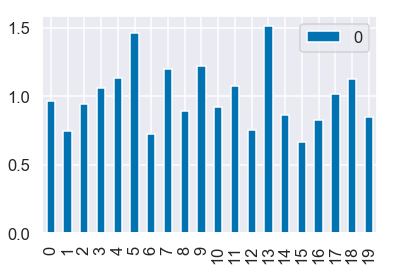

In [733]:
pd.DataFrame(random_rf.cv_results_['std_test_score'] * 100).plot(kind='bar')

In [734]:
random_rf.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=39,
            min_weight_fraction_leaf=0.0, n_estimators=107, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

#### Let's see how we performed...

In [735]:
random_rf.best_score_ 

0.03806228373702422

In [736]:
random_rf.score(X_test, y1_test)

0.015810276679841896

#### Let's build our next classifier for predicting the actual spread

In [737]:
random_rf.fit(X_train, y2_train)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.3min finished


RandomizedSearchCV(cv=10, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=20, n_jobs=-1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a675cba8>, 'max_features': ['sqrt', 'log2'], 'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a675c668>, 'bootstrap': [True, False], 'criterion': ['gini', 'entropy']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=1)

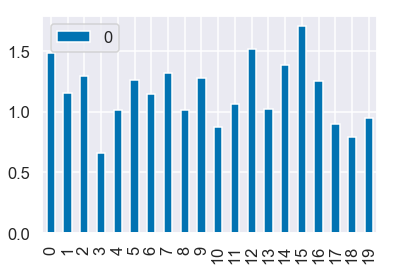

In [738]:
pd.DataFrame(random_rf.cv_results_['std_test_score'] * 100).plot(kind='bar')

In [739]:
random_rf.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=42,
            min_weight_fraction_leaf=0.0, n_estimators=138, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [740]:
random_rf.best_score_ 

0.0731586752347998

#### Let's see how we performed...

In [741]:
random_rf.score(X_test, y2_test)

0.08695652173913043

#### Let's build our next classifier for predicting if the favored team will win

In [742]:
random_rf.fit(X_train, y3_train)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   42.3s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   43.1s finished


RandomizedSearchCV(cv=10, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=20, n_jobs=-1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a675cba8>, 'max_features': ['sqrt', 'log2'], 'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a675c668>, 'bootstrap': [True, False], 'criterion': ['gini', 'entropy']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=1)

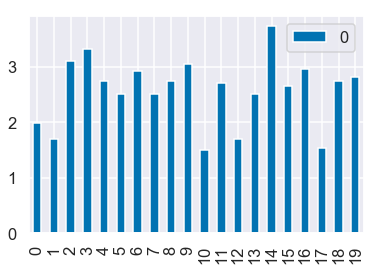

In [743]:
pd.DataFrame(random_rf.cv_results_['std_test_score'] * 100).plot(kind='bar')

In [744]:
random_rf.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=43,
            min_weight_fraction_leaf=0.0, n_estimators=39, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [745]:
random_rf.best_score_ 

0.661888284725655

#### Let's see how we performed...

In [746]:
random_rf.score(X_test, y3_test)

0.6561264822134387

#### Let's build our next classifier for predicting if the favored team will win within the predicted point spread

In [747]:
random_rf.fit(X_train, y4_train)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   47.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   49.3s finished


RandomizedSearchCV(cv=10, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=20, n_jobs=-1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a675cba8>, 'max_features': ['sqrt', 'log2'], 'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a675c668>, 'bootstrap': [True, False], 'criterion': ['gini', 'entropy']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=1)

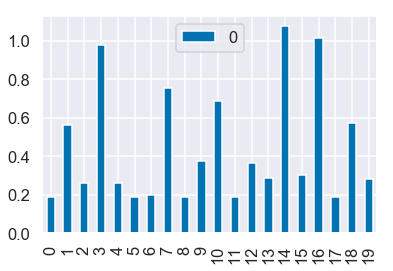

In [748]:
pd.DataFrame(random_rf.cv_results_['std_test_score'] * 100).plot(kind='bar')

In [749]:
random_rf.best_estimator_

RandomForestClassifier(bootstrap=False, class_weight=None,
            criterion='entropy', max_depth=None, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=43, min_weight_fraction_leaf=0.0,
            n_estimators=152, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [750]:
random_rf.best_score_ 

0.8161146811665843

#### Let's see how we performed...

In [751]:
random_rf.score(X_test, y4_test)

0.7944664031620553

#### Let's build our next classifier for predicting if actual over/under will be under the predicted over/under

In [752]:
random_rf.fit(X_train, y5_train)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   48.2s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   50.7s finished


RandomizedSearchCV(cv=10, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=20, n_jobs=-1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a675cba8>, 'max_features': ['sqrt', 'log2'], 'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a675c668>, 'bootstrap': [True, False], 'criterion': ['gini', 'entropy']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=1)

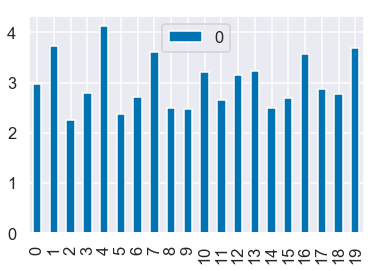

In [753]:
pd.DataFrame(random_rf.cv_results_['std_test_score'] * 100).plot(kind='bar')

In [754]:
random_rf.best_estimator_

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=44,
            min_weight_fraction_leaf=0.0, n_estimators=156, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [755]:
random_rf.best_score_ 

0.5101334651507662

#### Let's see how we performed...

In [756]:
random_rf.score(X_test, y5_test)

0.525691699604743

## Results

Accuracy of Prediction Models for Outcome of Betting Odds:
- Actual Over Under Line = ~3%
- Actual Point Spread = ~5%
- Favorited Team Did/Didn't Win = ~63%
- Favorited Team Did/Didn't Win within Projected Point Spread = ~79%
- Actual Combined Score is Under or Equal to Projected Over/Under Line = ~50%

Based on these results, it is clear that the prediction model can much more accurately whether or not an outcome will occur (True/False value) than it can the specific number outcomes for Over/Under and Spread. With a >75% prediction accuracy using this model, one can accurately predict whether or not the favored team will win within the projected point spread of and regular season game. This model is based on the week the game is played, the listed betting odds for the game (favored team, point spread, over/under line), the home team, the away team, stadium location (city), the stadium type (dome/open air), the stadium capacity, the field surface type, the game-time temperature, the game-time wind speed, the field elevation, and the conference matchup. There has been no analysis for which of these features are most valuable, but that is certainly a next step in improving the overall accuracy of the models. 

## Brining in External Data
I am bringing in population data for the purpose of trying to improve the best prediction model from above using the population of the city in which the NFL games were played. 

In [757]:
census = pd.read_csv("CensusData.csv")
census.head()

,StateAbbr,PlaceName,PlaceFIPS,Population2010,ACCESS2_CrudePrev,ACCESS2_Crude95CI,ACCESS2_AdjPrev,ACCESS2_Adj95CI,ARTHRITIS_CrudePrev,ARTHRITIS_Crude95CI,...,SLEEP_Adj95CI,STROKE_CrudePrev,STROKE_Crude95CI,STROKE_AdjPrev,STROKE_Adj95CI,TEETHLOST_CrudePrev,TEETHLOST_Crude95CI,TEETHLOST_AdjPrev,TEETHLOST_Adj95CI,Geolocation
0,CA,Folsom,624638,72203,7.5,"( 7.0, 8.0)",7.7,"( 7.2, 8.2)",16.9,"(16.6, 17.2)",...,"(32.7, 33.5)",1.9,"( 1.9, 2.0)",2.0,"( 2.0, 2.1)",6.8,"( 5.7, 8.0)",6.8,"( 5.7, 7.9)","(38.67504943280, -121.147605753)"
1,FL,Largo,1239425,77648,19.6,"(19.1, 20.2)",20.9,"(20.4, 21.5)",30.6,"(30.3, 30.9)",...,"(39.5, 40.1)",4.5,"( 4.4, 4.7)",3.2,"( 3.2, 3.3)",18.3,"(16.9, 19.8)",18.0,"(16.7, 19.4)","(27.90909077340, -82.7714203383)"
2,CA,Berkeley,606000,112580,7.7,"( 7.3, 8.1)",7.1,"( 6.8, 7.3)",15.1,"(15.0, 15.3)",...,"(32.3, 32.7)",1.9,"( 1.8, 1.9)",2.3,"( 2.2, 2.3)",6.7,"( 6.2, 7.2)",6.8,"( 6.3, 7.4)","(37.87256787650, -122.274907975)"
3,CA,Napa,650258,76915,12.3,"(11.8, 12.8)",12.7,"(12.1, 13.3)",20.7,"(20.5, 21.0)",...,"(32.7, 33.3)",2.8,"( 2.7, 2.9)",2.6,"( 2.5, 2.7)",11.2,"(10.0, 12.5)",11.2,"(10.0, 12.3)","(38.29804246490, -122.301093331)"
4,FL,Sunrise,1269700,84439,22.8,"(22.1, 23.5)",23.3,"(22.6, 24.1)",22.8,"(22.5, 23.1)",...,"(38.3, 38.8)",3.7,"( 3.5, 3.8)",3.3,"( 3.2, 3.4)",16.2,"(14.3, 18.5)",15.8,"(14.2, 17.7)","(26.15468783030, -80.2998411020)"


Now to extract the information we need.

In [758]:
pops = pd.DataFrame()
pops['State'] = census['StateAbbr']
pops['City'] = census['PlaceName']
pops['Population'] = census['Population2010']
pops.head()

,State,City,Population
0,CA,Folsom,72203
1,FL,Largo,77648
2,CA,Berkeley,112580
3,CA,Napa,76915
4,FL,Sunrise,84439


Need to add a column in the form of City, State to merge with original dataset.

In [759]:
pops['Location'] = pops[['City', 'State']].apply(lambda x: ', '.join(x), axis=1)
pops.head()

,State,City,Population,Location
0,CA,Folsom,72203,"Folsom, CA"
1,FL,Largo,77648,"Largo, FL"
2,CA,Berkeley,112580,"Berkeley, CA"
3,CA,Napa,76915,"Napa, CA"
4,FL,Sunrise,84439,"Sunrise, FL"


Now to merge...

In [760]:
external = data_final.merge(pops, how='left',left_on='stadium_location',right_on='Location')\
             .drop(labels=['State','City','Location'],axis=1)

Checking for missing data...

schedule_season          0
schedule_week            0
score_home               0
score_away               0
team_favorite_id         0
spread_favorite          0
over_under_line          0
weather_temperature      0
weather_wind_mph         0
Team ID_Home             0
Team ID_Away             0
stadium_location         0
stadium_type             0
stadium_capacity         0
stadium_surface          0
ELEVATION                0
C2C                      0
actual_o_u               0
Actual_OverUnder         0
actual_spread            0
FavoriteWon              0
Actual_Outcome           0
Population             355
dtype: int64


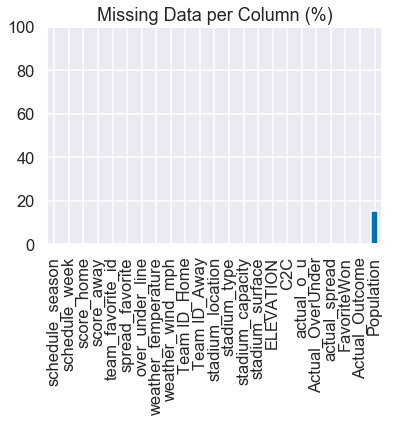

In [761]:
missing = external.isnull().sum()
print(missing)
missing = external.isnull().sum()/len(missing)
missing.plot.bar(title='Missing Data per Column (%)',ylim=[0,100])

In [762]:
blah = external.loc[lambda external:external['Population'].isnull()==True]
blah['stadium_location'].value_counts()

East Rutherford, NJ    144
Foxborough, MA          72
Landover, MD            72
Orchard Park, NY        67
Name: stadium_location, dtype: int64

In [763]:
external.loc[external.stadium_location == 'East Rutherford, NJ',['Population']] = 9928.0
external.loc[external.stadium_location == 'Foxborough, MA',['Population']] = 16693.0
external.loc[external.stadium_location == 'Landover, MD',['Population']] = 23078.0
external.loc[external.stadium_location == 'Orchard Park, NY',['Population']] = 29672.0

In [764]:
missing = external.isnull().sum()
print(missing)

schedule_season        0
schedule_week          0
score_home             0
score_away             0
team_favorite_id       0
spread_favorite        0
over_under_line        0
weather_temperature    0
weather_wind_mph       0
Team ID_Home           0
Team ID_Away           0
stadium_location       0
stadium_type           0
stadium_capacity       0
stadium_surface        0
ELEVATION              0
C2C                    0
actual_o_u             0
Actual_OverUnder       0
actual_spread          0
FavoriteWon            0
Actual_Outcome         0
Population             0
dtype: int64


Successful merge and fill!

Now the population column needs to be simplified into categorical variables for different population ranges.

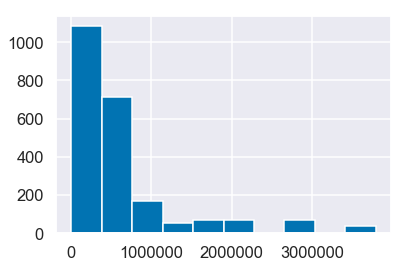

In [765]:
external['Population'].hist()

In [766]:
pop_dict = {
    'town': 100000,
    'city': 1000000,
    'metropolis': 10000000,
}

In [767]:
pop_ranges = pd.DataFrame(pop_dict, index=['STOP']).T.reset_index()
pop_ranges['START'] = (pop_ranges.STOP.shift(1)+1).fillna(0)
pop_ranges.index = pd.IntervalIndex.from_arrays(pop_ranges.START, pop_ranges.STOP, closed='both')
pop_ranges

,index,STOP,START
"[0.0, 100000.0]",town,100000,0.0
"[100001.0, 1000000.0]",city,1000000,100001.0
"[1000001.0, 10000000.0]",metropolis,10000000,1000001.0


In [768]:
external['Population'] = external['Population'].astype(int)
external['Population'] = external.Population.map(pop_ranges['index'])
external['Population'].value_counts()

city          1612
town           355
metropolis     309
Name: Population, dtype: int64

In [769]:
external.head()

,schedule_season,schedule_week,score_home,score_away,team_favorite_id,spread_favorite,over_under_line,weather_temperature,weather_wind_mph,Team ID_Home,...,stadium_capacity,stadium_surface,ELEVATION,C2C,actual_o_u,Actual_OverUnder,actual_spread,FavoriteWon,Actual_Outcome,Population
0,2010,1,14,9,NO,-5.0,49.5,warm,calm,NO,...,high,FieldTurf,low,NFCvsNFC,23,True,5,True,True,city
1,2010,1,10,15,MIA,-3.0,39.0,warm,light,BUF,...,medium,FieldTurf,low,AFCvsAFC,25,True,-5,True,False,town
2,2010,1,19,14,CHI,-6.5,45.0,warm,calm,CHI,...,medium,Grass,low,NFCvsNFC,33,True,5,True,True,metropolis
3,2010,1,34,24,IND,-1.0,48.0,hot,light,HOU,...,medium,Grass,low,AFCvsAFC,58,False,10,False,False,metropolis
4,2010,1,24,17,JAX,-3.0,41.5,hot,calm,JAX,...,medium,Grass,low,AFCvsAFC,41,True,7,True,False,city


Time to create more dummy variables for our new prediction model.

In [770]:
Dummy_Columns = ['team_favorite_id',
       'weather_temperature', 'weather_wind_mph', 'Team ID_Home',
       'Team ID_Away', 'stadium_location', 'stadium_type', 'stadium_capacity',
       'stadium_surface', 'ELEVATION', 'C2C', 'Population']
External = pd.get_dummies(data=external, columns = Dummy_Columns)
External.head()

,schedule_season,schedule_week,score_home,score_away,spread_favorite,over_under_line,actual_o_u,Actual_OverUnder,actual_spread,FavoriteWon,...,ELEVATION_high,ELEVATION_low,ELEVATION_medium,C2C_AFCvsAFC,C2C_AFCvsNFC,C2C_NFCvsAFC,C2C_NFCvsNFC,Population_city,Population_metropolis,Population_town
0,2010,1,14,9,-5.0,49.5,23,True,5,True,...,0,1,0,0,0,0,1,1,0,0
1,2010,1,10,15,-3.0,39.0,25,True,-5,True,...,0,1,0,1,0,0,0,0,0,1
2,2010,1,19,14,-6.5,45.0,33,True,5,True,...,0,1,0,0,0,0,1,0,1,0
3,2010,1,34,24,-1.0,48.0,58,False,10,False,...,0,1,0,1,0,0,0,0,1,0
4,2010,1,24,17,-3.0,41.5,41,True,7,True,...,0,1,0,1,0,0,0,1,0,0


Now, let's see how our best prediction model's accuracy is affected by this new information!

In [771]:
Final_columns = External.columns
Test_fs = ['actual_o_u','actual_spread','FavoriteWon','Actual_Outcome','Actual_OverUnder']
Drops = ['schedule_season', 'score_home', 'score_away']
Train_fs = [x for x in Final_columns if x not in Test_fs]
Train_fs = [x for x in Train_fs if x not in Drops]

In [772]:
Train_Data = External.loc[lambda External: External['schedule_season'] < 2018]
Test_Data = External.loc[lambda External: External['schedule_season'] >= 2018]
Train_Data = Train_Data.drop(labels = drops, axis=1)
Test_Data = Test_Data.drop(labels = drops, axis=1)

In [773]:
X_Train = Train_Data[Train_fs]
Y_Train = Train_Data['Actual_Outcome'].values
X_Test = Test_Data[Train_fs]
Y_Test = Test_Data['Actual_Outcome'].values
X_Train['over_under_line'] = X_Train['over_under_line'].round().astype(int)
X_Test['over_under_line'] = X_Test['over_under_line'].round().astype(int)
X_Train = X_Train.values
X_Test = X_Test.values

In [774]:
random_rf.fit(X_Train, Y_Train)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.2min finished


RandomizedSearchCV(cv=10, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=20, n_jobs=-1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a675cba8>, 'max_features': ['sqrt', 'log2'], 'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a675c668>, 'bootstrap': [True, False], 'criterion': ['gini', 'entropy']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=1)

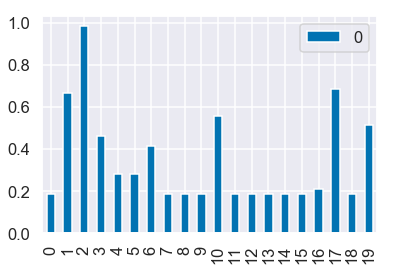

In [775]:
pd.DataFrame(random_rf.cv_results_['std_test_score'] * 100).plot(kind='bar')

In [776]:
random_rf.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=18,
            min_weight_fraction_leaf=0.0, n_estimators=293, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [777]:
random_rf.best_score_ 

0.8151260504201681

In [778]:
random_rf.score(X_Test, Y_Test)

0.7865612648221344

## Results
- Accuracy of Model with Population Data = ~78%
- Accuracy of Model without Population Data = ~79%

After bringing in population data to this model, the resulting prodiction accuracy is just below the accuracy of the model without this new information. It is hard to say for certain whether or not this new feature was relevant information for this predictive model, but the next steps of this study would be to identify the most impactful features for this dataset and it's different outcomes. 